In [5]:
col_names = [
    'dv', 
    'fv',
    'dv-fv'
]

In [6]:
import configparser
import warnings
import pandas as pd
from pymongo import MongoClient
import json
import requests
from bs4 import BeautifulSoup

warnings.filterwarnings("ignore", category=DeprecationWarning)

config = configparser.ConfigParser()
config.read('config.ini')
host = config['DEFAULT']['IP']
port = config['DEFAULT']['MongoDB-Port']

client = MongoClient(host, int(port))
db = client['Media-cloud']

In [7]:
def get_text(url):
    if '/?nk=' in url:
        return ''
        
    text = ''
    try:
        html = requests.get(url).text
        soup = BeautifulSoup(html)

        for p in soup.find_all('p'):
            if p.parent.get('class') == ['section']:
                continue
            if p.get('class') == ['_2g0-m']:
                continue
            sentence = p.get_text().strip()
            if (not sentence.startswith('A NOTE ABOUT RELEVANT ADVERTISING') and
                not sentence.startswith('If you have inside knowledge') and
                not sentence.startswith('ABC teams share the story') and
                not sentence.startswith('Read about our editorial') and
                not sentence.startswith('Sign up to receive')
               ) and (
                sentence.endswith('.') or 
                sentence.endswith("'") or
                sentence.endswith('"') or
                sentence.endswith("?") or
                sentence.endswith("!") or
                sentence.endswith(";") or
                sentence.endswith(",") or
                sentence.endswith(")") or
                sentence.endswith(":")
            ):
                text += sentence + ' '
                
        return text.strip()
    except:
        return text.strip()

In [17]:
for col_name in col_names:
    counter = 0
    print('Now processing:', col_name+'.csv')
    
    df = pd.read_csv('input/'+col_name+'.csv')
    df['text'] = ''
    for i, row in df.iterrows():
        url = row['url']
        df.at[i, 'text'] = get_text(url)
        
        counter += 1
        if counter % 100 == 0:
            print(counter, 'records processed')
            
    col = db[col_name]
    records = json.loads(df.to_json(orient='records'))
    col.insert_many(records)
    
    print(col_name+'.csv finished\n--------------------\n')

Now processing: dv.csv
100 records processed
200 records processed
300 records processed
400 records processed
500 records processed
600 records processed
700 records processed
800 records processed
900 records processed
1000 records processed
1100 records processed
1200 records processed
1300 records processed
1400 records processed
1500 records processed
1600 records processed
1700 records processed
1800 records processed
1900 records processed
2000 records processed
2100 records processed
2200 records processed
2300 records processed
2400 records processed
2500 records processed
2600 records processed
2700 records processed
2800 records processed
2900 records processed
3000 records processed
3100 records processed
3200 records processed
3300 records processed
3400 records processed
3500 records processed
3600 records processed
3700 records processed
3800 records processed
3900 records processed
4000 records processed
4100 records processed
4200 records processed
4300 records process

## Venn Diagram

In [8]:
from matplotlib_venn import venn2
from matplotlib import pyplot as plt
%matplotlib inline

In [9]:
count_fv = db['fv'].find({}).count()
count_dv = db['dv'].find({}).count()
count_fv_dv = db['dv-fv'].find({}).count()

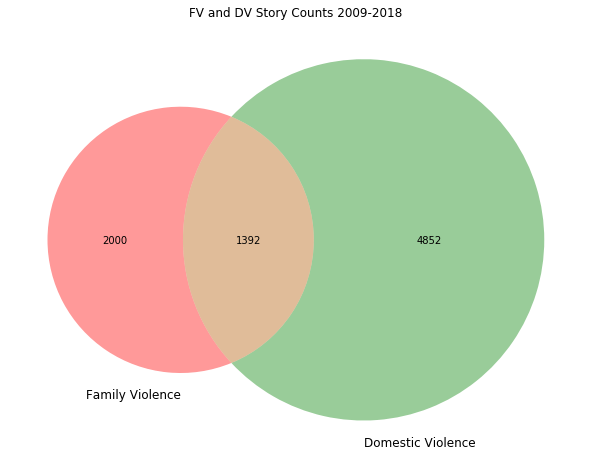

In [10]:
plt.figure(figsize=(12,8))
plt.title('FV and DV Story Counts 2009-2018')
venn2(subsets = (count_fv, count_dv, count_fv_dv), set_labels = ('Family Violence', 'Domestic Violence'))
plt.show()

## Top Words

In [21]:
import mediacloud.api
import datetime

mc_key = config['MEDIACLOUD']['Key']
mc = mediacloud.api.MediaCloud(mc_key)

In [22]:
words = mc.wordCount('"domestic violence" OR "family violence" AND tags_id_media:38378025',
                     mc.publish_date_query( datetime.date( 2009, 1, 1), datetime.date( 2018, 12, 31)))

In [24]:
freqs = {}
for word in words:
    term = word['term']
    freqs[term] = freqs.get(term, 0) + 1

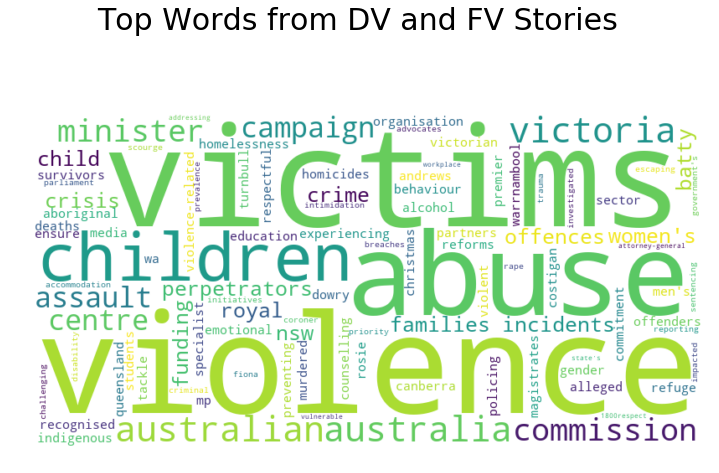

In [28]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, max_words=100, background_color="white")
wordcloud.generate_from_frequencies(frequencies=freqs)

plt.figure(figsize=(12,8)).suptitle('Top Words from DV and FV Stories', fontsize=30)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Word Space / N-Gram?

In [29]:
df = pd.read_csv('input/word_space.csv')

In [62]:
import numpy as np

xs = []
ys = []
labels = []

for i, row in df.iterrows():
    x = row['google_w2v_x']
    y = row['google_w2v_y']
    if not np.isnan(x) and not np.isnan(y): 
        xs.append(x)
        ys.append(y)
        labels.append(row['term'])
        
        if i == 25:
            break

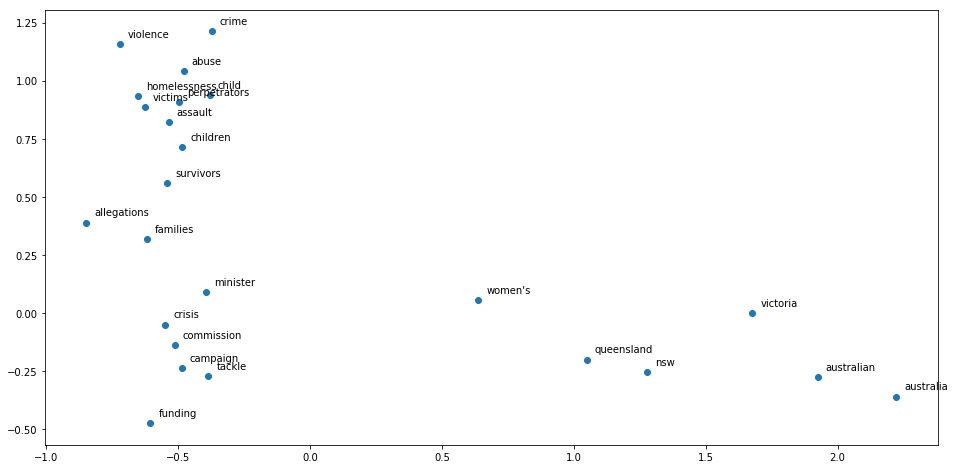

In [63]:
plt.figure(figsize=(16,8))
plt.scatter(xs, ys)

for i, txt in enumerate(labels):
    plt.annotate(txt, (xs[i], ys[i]), (xs[i]+0.03, ys[i]+0.03))

## Themes

In [66]:
freq = {}
for col_name in col_names:
    col = db[col_name]
    counter = 0
    
    for story in col.find({}):
        s = story['themes']
        if s != None:
            for split in s.split(','):
                theme = split.strip()
                freq[theme] = freq.get(theme, 0) + 1
                
        counter += 1
        if counter % 500 == 0:
            print(counter, 'processed')

500 processed
1000 processed
1500 processed
2000 processed
2500 processed
3000 processed
3500 processed
4000 processed
4500 processed
500 processed
1000 processed
1500 processed
2000 processed
500 processed
1000 processed


In [97]:
total = 0
for _, count in freq.items():
    total += count

labels = []
sizes = []
n = 0
total_top = 0
for theme in sorted(freq, key=freq.get, reverse=True):
    labels.append(theme)
    theme_freq = freq[theme]
    sizes.append(theme_freq)
    total_top += theme_freq
    n += 1
    if n == 15:
        break
    
labels.append('others')
sizes.append(total-total_top)

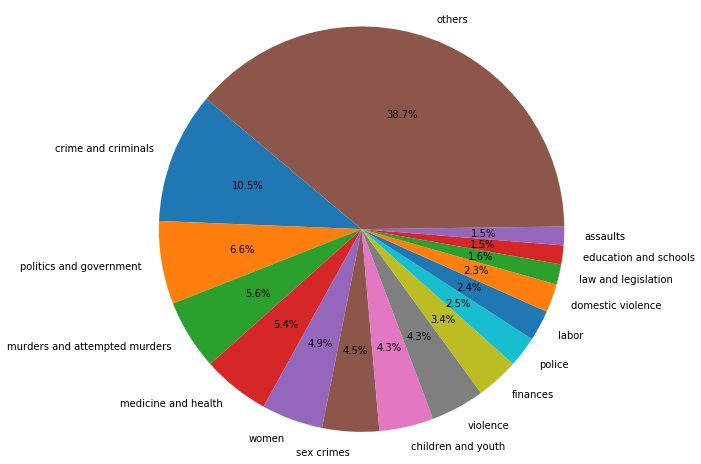

In [99]:
plt.figure(figsize=(8,8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
 
plt.axis('equal')
plt.show()